# 1.  Import python dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio

# 2. Location

For this tutorial, we’ll use the NIR and Red bands from a Landsat-8 scene above part of the central valley and the Sierra Nevada in California. We’ll be using Level 1TP datasets, orthorectified, map-projected images containing radiometrically calibrated data.

# 3. Amazon web services (AWS) and Google Cloud

You can use NASA’s Earthdata Search website to discover data. 
Landsat images are organized by ‘path’ and ‘row’. We’ve chosen a scenes from path 42, row 34, that doesn’t have many clouds present (LC08_L1TP_042034_20170616_20170629_01_T1). Note that ‘T1’ stands for ‘Tier 1’ (for analytic use), and ‘RT’ stands for ‘Real-time’, for which quality control is not as rigorous. 
Read more about the various Landsat formats and collections here. 

The advantage of this approach is that you do not need to download the image locally before perfroming your analysis. You can pull the image into your workspace from the cloud via image folder links as demonstrated below.

Finding and loading the data with both AWS or Google Cloud follow the same workflow. 

For example, look at the band 4 image for the date we selected below:

#### AWS sample link

In [6]:
print('Landsat on AWS:')
print('=========================')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


#### Google cloud sample link

In [8]:
print('Landsat on Google cloud:')
print('=========================')
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google cloud:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


# 4. Bands needed from land surface temperature computation
- Red: Band 4
- Near-Infrared (NIR): Band 5
- Thermal infrared 1: Band 10
- Thermal infrared 2: Band 11

Here, I have used `rasterio` to load the images/bands needed.

In [48]:
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
#url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4) # L1TP_216074_20160531_20180528_01_T1_B4.TIF'
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)
tempband10 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(10)
tempband11 = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(11)

In [50]:
with rasterio.open(url+redband) as src:
    redImage = src.read(1).astype('f4')

with rasterio.open(url+nirband) as src:
    nirImage = src.read(1).astype('f4')
    
with rasterio.open(url+tempband10) as src:
    tempImage10 = src.read(1).astype('f4')

with rasterio.open(url+tempband11) as src:
    tempImage11 = src.read(1).astype('f4')

### Visualize the Red and NIR band images

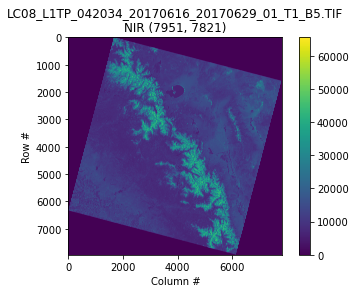

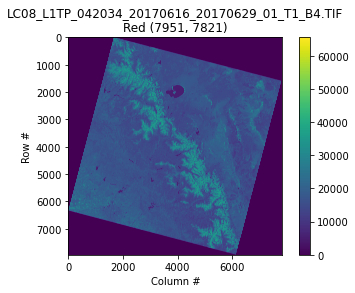

In [6]:
plt.imshow(redImage)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nirImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(nirImage)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, redImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

### Create a mask variable that will be used all through this notebook

The idea is that we do not want to compute or displace the land surface temperature over parts of the Thermal Infre-red image with reflactance values of zero. We can thus create a mask here to help improve our visualization of the thermal IR images. Note that this masking is automatically handled in the landtemp module. You won't have to create the mask by yourself.

In [7]:
# Creating and applying the mask to the images.
mask = tempImage10 == 0
tempImage10[mask] = np.nan
tempImage11[mask] = np.nan

### Visualize the  thermal IR bands (10 and 11)

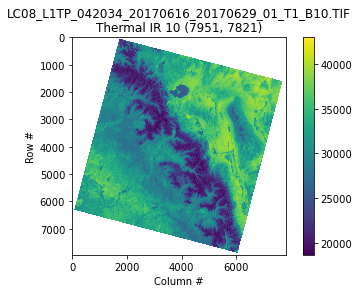

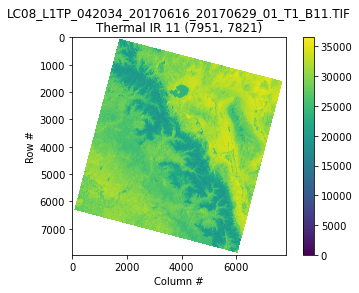

In [8]:
plt.imshow(tempImage10)
plt.colorbar()
plt.title('{}\nThermal IR 10 {}'.format(tempband10, tempImage10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(tempImage11)
plt.colorbar()
plt.title('{}\nThermal IR 11 {}'.format(tempband11, tempImage10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 5. Compute the Normalized Difference Vegetation Index (NDVI) image from the Red and NIR images 
### (OPTIONAL: only needed if your sole objective is to compute emissivity or NDVI)

We need the NDVI (and in some cases) the red band image to obtain our emissivity image.
The Normalized Difference Vegetation Index is a simple indicator that can be used to assess whether the target includes healthy vegetation. This calculation uses two bands of a multispectral image dataset, the Red and Near-Infrared (NIR) bands.

This stage is only done here in the tutorial for completion. The `emissivity` module of `landtemp` handles the NDVI computation automatically. However, if you need to compute NDVI for other purposes you can follow the workflow below:

In [9]:
from landtemp import ndvi

In [10]:
ndviImage = ndvi(nirImage, redImage, mask=mask)

### Visualize NDVI

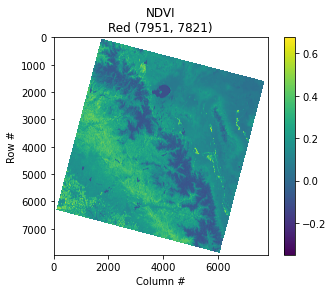

In [11]:
plt.imshow(ndviImage)
plt.colorbar()
plt.title('{}\nRed {}'.format('NDVI', ndviImage.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 6. Compute emissivity

### (OPTIONAL: only needed if your sole objective is to compute emissivity. If you simply want the land surface temperature, you can skip this)

In [12]:
from landtemp import emissivity

In [13]:
emissivity_10, emissivity_11 = emissivity(ndviImage, emissivity_method='gopinadh')

### Visualize the emissivity computed for thermal IR bands (10 and 11)

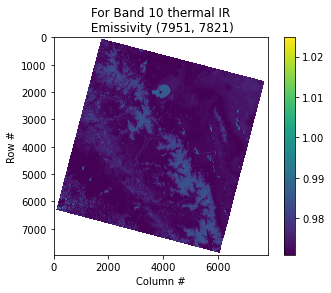

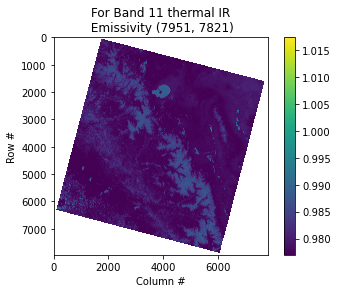

In [14]:
plt.imshow(emissivity_10)
plt.colorbar()
plt.title('{}\n Emissivity {}'.format('For Band 10 thermal IR', emissivity_10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(emissivity_11)
plt.colorbar()
plt.title('{}\n Emissivity {}'.format('For Band 11 thermal IR', emissivity_11.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 7. Obtain brightness temperature

### (OPTIONAL: only needed if your sole objective is to compute emissivity. If you simply want the land surface temperature, you can skip this)

In [15]:
from landtemp import brightness_temperature

In [16]:
brightness_temp_10, brightness_temp_11 = brightness_temperature(tempImage10, tempImage11, mask)


### Visualize the  brightness temperature computed for bands (10 and 11)

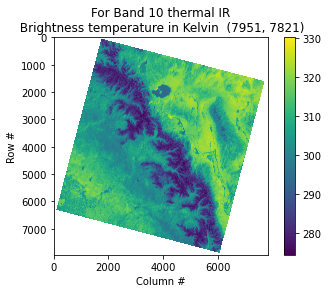

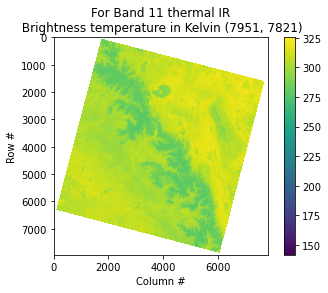

In [17]:
plt.imshow(brightness_temp_10)
plt.colorbar()
plt.title('{}\n Brightness temperature in Kelvin  {}'.format('For Band 10 thermal IR', brightness_temp_10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()


plt.imshow(brightness_temp_11)
plt.colorbar()
plt.title('{}\n Brightness temperature in Kelvin {}'.format('For Band 11 thermal IR', brightness_temp_11.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 8. Compute land surface temperature

In [18]:
from landtemp import split_window, single_window

### Split window

In [53]:
method = 'mc-clain'
lst_image_split_window = split_window(
                                tempImage10, 
                                tempImage11, 
                                redImage, 
                                nirImage, 
                                lst_method=method, 
                                emissivity_method='avdan',
                                unit='celcius'
        )

##### Visualize the  Land Surface Temperature obtained

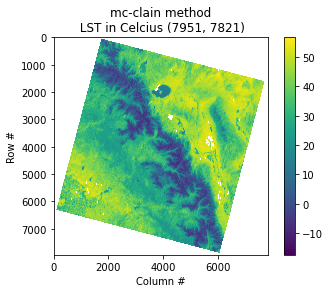

In [56]:
plt.imshow(lst_image_split_window)
plt.colorbar()
plt.title('{}\n LST in Celcius {}'.format(f'{method} method', lst_image_split_window.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

### Single window

In [57]:
lst_image_single_window = single_window(tempImage10, redImage, nirImage, unit='celcius')

##### Visualize the  Land Surface Temperature obtained

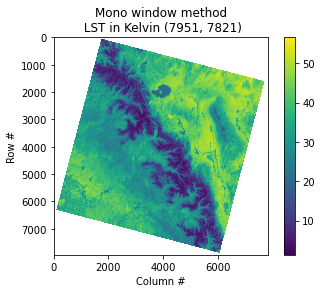

In [22]:
plt.imshow(lst_image_single_window)
plt.colorbar()
plt.title('{}\n LST in Kelvin {}'.format(f'Mono window method', lst_image_single_window.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()